## Goal: Evaluate Employee Eentiment and Engagement by Performing the Following:

 1. Sentiment Labeling: Automatically label each message as Positive, Negative, or Neutral.

 2. Exploratory Data Analysis (EDA): Analyze and visualize the data to understand its structure and underlying trends.

 3. Employee Score Calculation: Compute a monthly sentiment score for each employee based on their messages.

 4. Employee Ranking: Identify and rank employees by their sentiment scores.

 5. Flight Risk Identification: A Flight risk is any employee who has sent 4 or more negative mails in a given month.

 6. Predictive Modeling: Develop a linear regression model to further analyze sentiment trends.

In [547]:
#Loading Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [548]:
#Reading Data
df=pd.read_csv('test.csv')
df.describe()

,Subject,body,date,from
count,2191,2191,2191,2191
unique,1251,1539,690,10
top,(No Subject),\n\n,7/1/2011,lydia.delgado@enron.com
freq,141,21,9,284


In [549]:
#Checking what the data looks like
df.head()

,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com


In [550]:
#Checking missing values
df.isnull().sum()

Subject    0
body       0
date       0
from       0
dtype: int64

In [551]:
#Making data consistent
df['Subject']=df['Subject'].str.lower()
df['body']=df['body'].str.lower()


# 1. Using VADER to Label Sentiments

In [552]:
#Vader Sentiment Analyzer
from nltk.sentiment import SentimentIntensityAnalyzer

sa=SentimentIntensityAnalyzer()

In [553]:
#Calculating Polarity Scores of the entire Dataset
sent_df= df['body'].apply(lambda x: sa.polarity_scores(x)).apply(pd.Series)

In [554]:
#Concatinating Polarity Scores
df = pd.concat([df, sent_df], axis=1)

In [555]:
df.head()

,Subject,body,date,from,neg,neu,pos,compound
0,enronoptions update!,enronoptions announcement\n\n\nwe have updated...,5/10/2010,sally.beck@enron.com,0.000,0.920,0.08,0.8172
1,(no subject),"marc,\n\nunfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com,0.042,0.868,0.09,0.4215
2,phone screen interview - shannon l. burnham,"when: wednesday, june 06, 2001 10:00 am-11:00 ...",7/25/2011,sally.beck@enron.com,0.000,1.000,0.00,0.0000
3,re: my new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com,0.000,1.000,0.00,0.0000
4,bet,since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com,0.000,0.950,0.05,0.2500


# 2. EDA

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


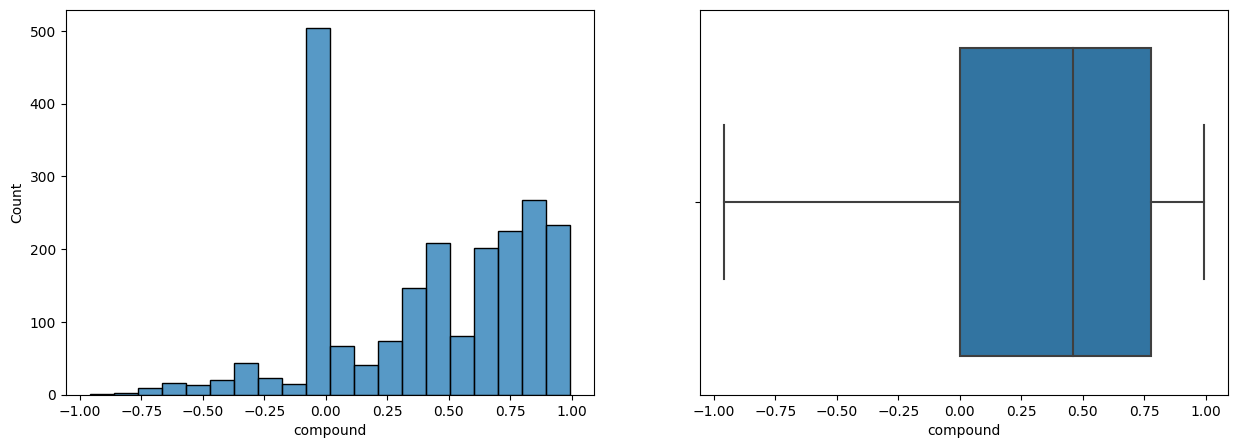

In [556]:
#Plotting Compound Data to Find Trends
fig,axs = plt.subplots(1,2,figsize=(15,5))

sns.histplot(data=df, x='compound', bins=20,ax=axs[0])
sns.boxplot(data=df,x ='compound',ax=axs[1])
plt.show()


In [557]:
#Extracting Different Domains
df['domain'] = df['from'].str.extract(r'@([\w\.]+)')


<Axes: xlabel='compound', ylabel='domain'>

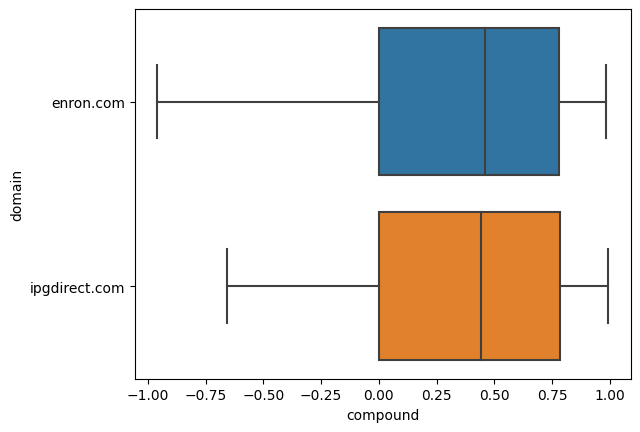

In [558]:
#Plotting Compound Data Against Different Domains
sns.boxplot(data=df, x='compound', y='domain')

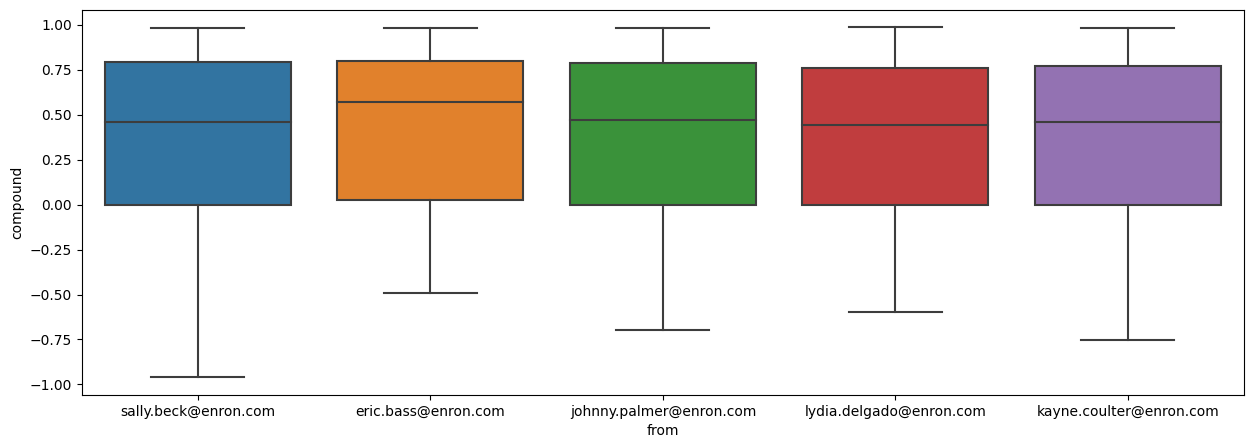

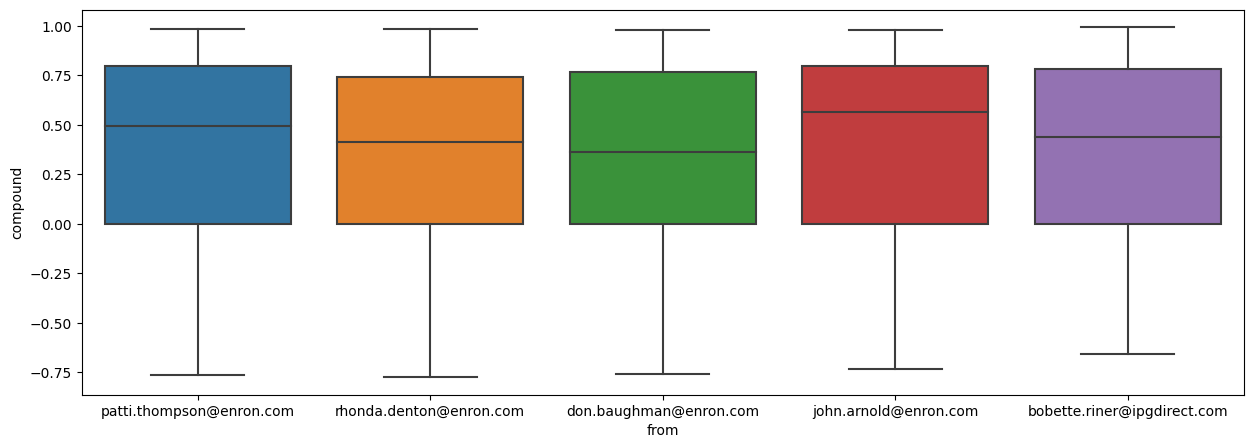

In [559]:
# Plotting Compound Data Against Each Employee 
# and Creating Groups of Employees for better readibility
unique_employees = df['from'].unique()
step = 5

for i in range(0, len(unique_employees), step):
    subset_emps = unique_employees[i:min(i+step,len(unique_employees))]
    subset_df = df[df['from'].isin(subset_emps)]

    plt.figure(figsize=(15, 5))
    sns.boxplot(data=subset_df, x='from', y='compound')
    plt.show()

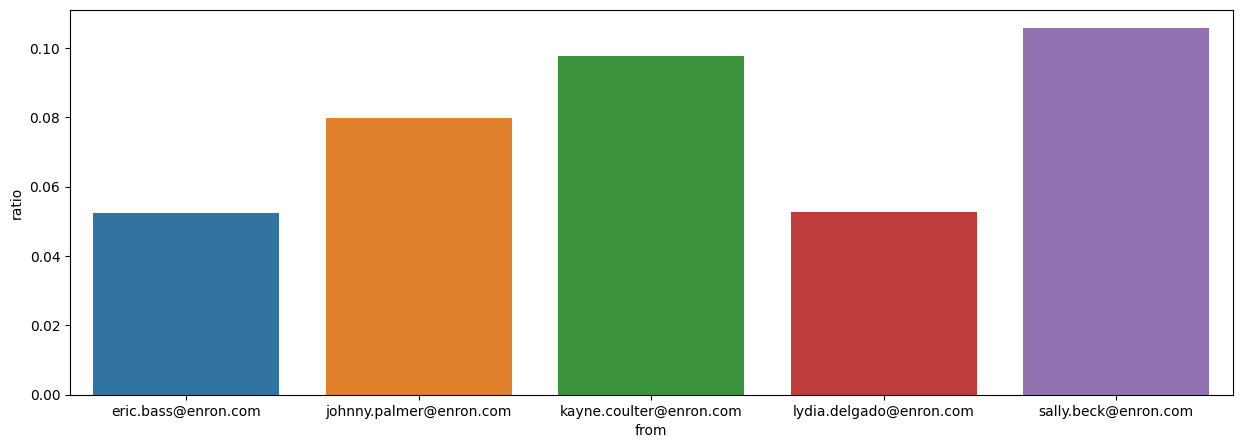

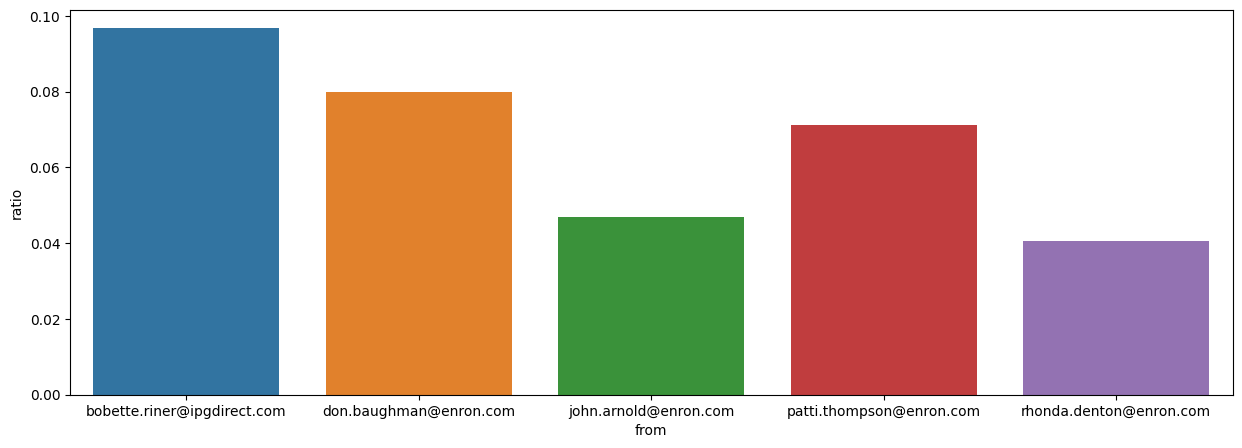

In [560]:
#Calculating Ratio of Emails with Negative Sentiment to Total Number of Emails
# Plotting Compound Data Against Each Employee 
# and Creating Groups of Employees for better readibility

unique_employees = df['from'].unique()
step = 5

neg_df=df[df['compound']<0]
all_ratios=[]
for i in range(0, len(unique_employees), step):
    subset_emps = unique_employees[i:min(i+step,len(unique_employees))]
    
    subset_all = df[df['from'].isin(subset_emps)]
    subset_neg = neg_df[neg_df['from'].isin(subset_emps)]

    total_counts = subset_all['from'].value_counts()
    neg_counts = subset_neg['from'].value_counts()
    
    ratio = (neg_counts / total_counts).fillna(0)
    ratio_df = ratio.reset_index()
    ratio_df.columns = ['from', 'ratio']
    all_ratios.append(ratio_df)

    plt.figure(figsize=(15, 5))
    sns.barplot(data=ratio_df, x='from', y='ratio')
    plt.show()

In [561]:
#Concatenating Data of Different Employee Groups
df_ratios = pd.concat(all_ratios, ignore_index=True)
print(df_ratios)

                          from     ratio
0          eric.bass@enron.com  0.052381
1      johnny.palmer@enron.com  0.079812
2      kayne.coulter@enron.com  0.097701
3      lydia.delgado@enron.com  0.052817
4         sally.beck@enron.com  0.105727
5  bobette.riner@ipgdirect.com  0.096774
6       don.baughman@enron.com  0.079812
7        john.arnold@enron.com  0.046875
8     patti.thompson@enron.com  0.071111
9      rhonda.denton@enron.com  0.040698


In [562]:
#Merging Ratios into the Original Dataframe
df = df.merge(df_ratios, on='from', how='right')


In [563]:
df.head()

,Subject,body,date,from,neg,neu,pos,compound,domain,ratio
0,(no subject),"marc,\n\nunfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com,0.042,0.868,0.090,0.4215,enron.com,0.052381
1,re: favor,"sure, just call me the bank that delivers.\n \...",10/23/2011,eric.bass@enron.com,0.000,0.901,0.099,0.3182,enron.com,0.052381
2,re: transmission agreements meeting tues. jan....,"jim, christi,\n\nare you available to attend t...",12/18/2011,eric.bass@enron.com,0.000,0.925,0.075,0.2732,enron.com,0.052381
3,firstenergy system to american transmission sy...,firstenergy system (firstenesy) has assigned i...,9/3/2010,eric.bass@enron.com,0.000,0.884,0.116,0.4215,enron.com,0.052381
4,candidate contact information,dear team members:\n\nplease disregard the lis...,9/13/2010,eric.bass@enron.com,0.098,0.745,0.157,0.4215,enron.com,0.052381


# Observations:
- Imbalanced Distribution : Negatively Skewed
- Neutral Sentiments and Positive Sentiments Dominate Negative Sentiments
- Some Employees had More Emails with Negative Sentiments than others
- Sentiment Trends are similar accross Different Domain Users


In [564]:
#Converting to Datetime
df['date'] =pd.to_datetime(df['date'])

# 3. Employee Monthly Scores

In [565]:
#function to calculate to convert compound value to 1,0,-1
def message_compound(value):
    if(value==0):
        return 0
    elif(value>0):
        return 1
    return -1

In [566]:
df['message_score']=df['compound'].apply(message_compound)

In [567]:
# Extracting Year-Month Pairs
df['year_month']=df['date'].dt.to_period('M') 

In [568]:
#grouping by from and year_month creates a group for every employee with subgroups for all months
# the final sum provides the monthly score
monthly_score = df.groupby(['from', 'year_month'])['message_score'].sum().reset_index().rename(columns={'message_score':'monthly_score'})

In [569]:
print(monthly_score)

                            from year_month  monthly_score
0    bobette.riner@ipgdirect.com    2010-01              1
1    bobette.riner@ipgdirect.com    2010-02              7
2    bobette.riner@ipgdirect.com    2010-03              6
3    bobette.riner@ipgdirect.com    2010-04              3
4    bobette.riner@ipgdirect.com    2010-05              2
..                           ...        ...            ...
235         sally.beck@enron.com    2011-08              3
236         sally.beck@enron.com    2011-09              1
237         sally.beck@enron.com    2011-10              6
238         sally.beck@enron.com    2011-11              5
239         sally.beck@enron.com    2011-12              5

[240 rows x 3 columns]


# 4. Employee Ranking

In [570]:
## First group by year_month to get employees for every month
## apply nlargest and nsmallest on every group
pos_top3 = monthly_score.groupby('year_month').apply(lambda x:x.nlargest(3,'monthly_score'),include_groups=False).reset_index(level=1,drop=True)
    pos_top3.sort_values(by=['year_month','monthly_score','from'],ascending=[True,False,True])

,from,monthly_score
year_month,,
2010-01,kayne.coulter@enron.com,13
2010-01,eric.bass@enron.com,9
2010-01,lydia.delgado@enron.com,9
2010-02,john.arnold@enron.com,11
2010-02,johnny.palmer@enron.com,10
...,...,...
2011-11,bobette.riner@ipgdirect.com,9
2011-11,john.arnold@enron.com,9
2011-12,eric.bass@enron.com,12


In [571]:
neg_top3 = monthly_score.groupby('year_month').apply(lambda x:x.nsmallest(3,'monthly_score'),include_groups=False).reset_index(level=1,drop=True)
neg_top3.sort_values(by=['year_month','monthly_score','from'],ascending=[True,False,True])

,from,monthly_score
year_month,,
2010-01,bobette.riner@ipgdirect.com,1
2010-01,johnny.palmer@enron.com,1
2010-01,rhonda.denton@enron.com,1
2010-02,kayne.coulter@enron.com,1
2010-02,lydia.delgado@enron.com,1
...,...,...
2011-11,rhonda.denton@enron.com,2
2011-11,eric.bass@enron.com,1
2011-12,john.arnold@enron.com,4


# 5. Flight Risks

In [572]:
#Filtering Message with negative sentiment
df_neg=df[df['message_score']==-1]

In [573]:
#Filtering Message with negative sentiment
df_neg=df[df['message_score']==-1]

flight_risks=set()

#sorting and indexing required for rolling window
df_neg = df_neg.sort_values('date')
df_neg= df_neg.set_index('date')
for employee,row in df_neg.groupby('from'):
    rolling_count = row['message_score'].rolling('30D').sum()
    if(rolling_count<=-4).any():
        flight_risks.add(employee)

In [574]:
print(flight_risks)

{'johnny.palmer@enron.com', 'bobette.riner@ipgdirect.com', 'john.arnold@enron.com', 'don.baughman@enron.com', 'sally.beck@enron.com'}


# 6. Regression Model

In [575]:
#word counts of body and subject
df['body_word_count'] = df['body'].str.split().apply(len)
df['Subject_word_count'] = df['Subject'].str.split().apply(len)

In [576]:
#total number of exclamation marks
df['total_exclamations'] = df['body'].str.count('!') + df['Subject'].str.count('!')
df['total_punc'] = df['body'].str.count(r'[\;\,\.\?]+')
# day and month columns
df['month']=df['date'].dt.month
df['day']=df['date'].dt.day

In [577]:
#extracting average body word count for each employee
temp = df.groupby('from')['body_word_count'].mean().reset_index().rename(columns={'body_word_count':'avg_body_word_count'})
df = df.merge(temp, on='from', how='left')


In [578]:
#extracting average message each month for each employee
temp=df.groupby(['year_month', 'from']).size().reset_index(name='avg_monthly_message_count')
temp.drop('year_month',axis=1,inplace=True)
temp=temp.groupby('from').mean()

df = df.merge(temp, on='from', how='left')

In [579]:
#extracting message count w.r.t each month for each employee
df['message_count']=df.groupby(['from','year_month']).cumcount()+1

In [580]:
#matches all negative words
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize

neg_words =set(opinion_lexicon.negative())
pos_words=set(opinion_lexicon.positive())

def match_all_negative(text):
    words=word_tokenize(text)
    return sum(1 for word in words if word in neg_words)
    
def match_all_positive(text):
    words=word_tokenize(text)
    return sum(1 for word in words if word in pos_words)
    

In [581]:
df['negative_word_count']= df['body'].apply(match_all_negative)
df['positive_word_count']= df['body'].apply(match_all_positive)

In [582]:
#normalizing columns
df['normalized_message_count']=  df['message_count'] / df['avg_monthly_message_count'] 
df['normalized_negative_word_count']=  df['negative_word_count'] / df['body_word_count']
df['normalized_positive_word_count']=  df['positive_word_count'] / df['body_word_count']
df['normalized_total_exclamations']=  df['total_exclamations'] / df['body_word_count']
df['normalized_total_punc']=  df['total_punc'] / df['body_word_count']
df=df.fillna(0)

In [583]:
#checking correlation for message_score
df.corr(numeric_only=True)['compound']

neg                              -0.352513
neu                              -0.205769
pos                               0.473296
compound                          1.000000
ratio                            -0.038531
message_score                     0.833917
body_word_count                   0.437515
Subject_word_count                0.087147
total_exclamations                0.162116
total_punc                        0.338526
month                             0.042968
day                              -0.007630
avg_body_word_count               0.064868
avg_monthly_message_count         0.014027
message_count                     0.001218
negative_word_count              -0.021916
positive_word_count               0.527852
normalized_message_count         -0.000971
normalized_negative_word_count   -0.199058
normalized_positive_word_count    0.242772
normalized_total_exclamations    -0.014246
normalized_total_punc            -0.134199
Name: compound, dtype: float64

In [584]:
#Import libraries essential for model training
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score,accuracy_score

In [607]:
#assigning features (only with correlation > 0.05) and target columns
target= ['compound']
features = ['Subject_word_count',
                 'body_word_count','normalized_message_count','normalized_total_exclamations','normalized_total_punc',
                     'normalized_negative_word_count','positive_word_count']

y = df[target]
X = df[features]

In [608]:
#Create Train Test Sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=42)

In [609]:
from sklearn.model_selection import GridSearchCV

model= GridSearchCV(LinearRegression(), param_grid={}, cv=10)
model.fit(X_train, y_train)
model = model.best_estimator_


In [610]:
#Accuracy Metrics
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.09814340849189754
R-squared: 0.3722092739255094


In [611]:
y_pred = y_pred.flatten()
y_test = y_test.values.flatten()

In [625]:
conditions_1 = [y_pred < 0, y_pred<.15, y_pred >0]
conditions_2 = [y_test < 0, y_test==0, y_test >0]

choices = [-1, 0, 1]

y_pred_cat = np.select(conditions_1, choices)
y_test_cat= np.select(conditions_2, choices)

Accuracy: 0.7097


Text(0.5, 1.0, 'Confusion Matrix ')

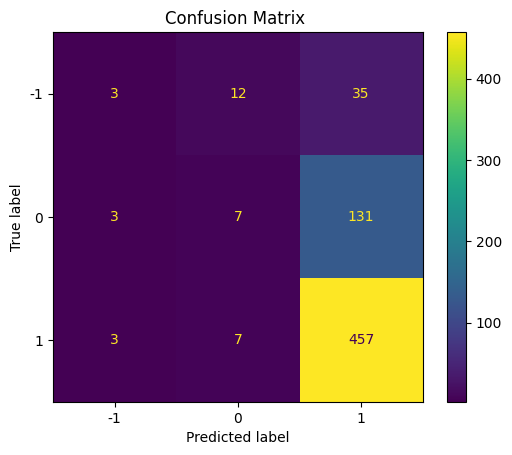

In [626]:
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay

accuracy = accuracy_score(y_test_cat, y_pred_cat)
print(f"Accuracy: {accuracy:.4f}")

ConfusionMatrixDisplay.from_predictions(y_test_cat, y_pred_cat)
plt.title("Confusion Matrix ")

# Observations

- The model does have an 0.7 accuracy but that is not a good metric as data is positive - dominant.
- The 0.34 Correlation suggests that the model is not great but is better than taking the average.
- The 0.09 MSE or 0.3 RMSE gives the average error.

# Conclusion
- The Model is Not Terrible but Not Highly Accurate Either.
- A More Complex Model than LinearRegression is needed